In [1]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.neighbors import KNeighborsRegressor
from time import time
from sklearn import metrics
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from scipy.interpolate import spline
from sklearn.impute import SimpleImputer
from collections import Counter 
from datetime import datetime
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('boscun-longitudinal.csv')

In [3]:
data.head()

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,...,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class
0,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,2016-04-21,1461268013357,BOS,CUN,397.0,ADT,NaN,AM,...,615,1,AM,2,42,4,True,8,E,E
1,f079363a-b281-3476-b13e-d96ba6a8ad8a,15,2016-04-21,1461268013357,BOS,CUN,412.8,ADT,NaN,UA,...,492,1,UA,2,42,4,True,8,E,E
2,f079363a-b281-3476-b13e-d96ba6a8ad8a,17,2016-04-21,1461268013357,BOS,CUN,412.8,ADT,NaN,UA,...,526,1,UA,2,42,4,True,8,E,E
3,f079363a-b281-3476-b13e-d96ba6a8ad8a,19,2016-04-21,1461268013357,BOS,CUN,412.8,ADT,NaN,UA,...,405,1,UA,2,42,4,True,8,E,E
4,f079363a-b281-3476-b13e-d96ba6a8ad8a,29,2016-04-21,1461268013357,BOS,CUN,412.8,ADT,NaN,UA,...,526,1,UA,2,42,4,True,9,E,E


In [4]:
len(list(set(data['trip_index'])))

388

#### There are 388 unique trip indices in the dataset

In [5]:
data.shape

(3009408, 26)

In [6]:
# Shuffling the data so that same departure and return dates don't get clustered together

data = shuffle(data)

In [7]:
training_set = data.head(1500000)
held_out_set = data.iloc[1500000:]

In [8]:
training_set.shape

(1500000, 26)

In [9]:
held_out_set.shape

(1509408, 26)

Hopper Quant Analyst Exercise
===

Background
---

Hopper receives several billion priced air itineraries every day, in near real-time.
Each trip is part of a bundle of trips indicated by a search identifier.
Usually a bundle of trips is a set of alternative flights resulting from
a consumer flight search at an online travel agency (OTA).
For example, a user might search for flights from BOS to JFK, perhaps including nearby airports,
with particular (possibly flexible) departure and return dates.
The search returns many possible priced trip options, which forms a bundle of trips.
Hopper doesn't receive any information about whether a trip was purchased,
what the original query was, or any user-identifiable information.

Files
--

 - README.md: this file
 - boscun-longitudinal.csv.gz, a gzipped CSV file with about 3M trip records collected for a particular route
 - metadata for the CSV is provided below
 
Goal
---

This exercise includes a small sample of all the searches we saw for round-trip flights from Boston to Cancun
over a period of about 18 months, with a small subset of potentially interesting features for each trip.
Imagine that a Hopper user wants to travel this route on particular departure and return dates, 
and checks the price on some earlier date.  
Illustrate how you'd use a dataset like this to advise the user at that time whether they should buy the ticket
or wait for a better price.

We're not expecting a production-quality solution, and are more interested in your approach and understanding of the issues involved.  Please feel free to use whatever tools you like, 
and provide a short discussion (max 500 words) outlining your findings, methodology,
and any key remaining issues you'd want to tackle in production.

Metadata
---

- search_id: the bundle identifer 
- trip_index: the index of the trip within a bundle
- received_date: date the trip was received at Hopper
- received_ms: epoch milliseconds trip was received
- origin: origin airport
- destination: destination airport
- total_usd: total fare including taxes and fees
- pax_type: passenger type quoted
- refundable: refundable fare indicator
- validating_carrier: airline selling the ticket
- departure_odate: departure date in origin TZ
- departure_ms: epoch milliseconds of departure
- outgoing_duration: total in minutes 
- outgoing_stops: number of stops on outbound trip
- return_odate: return date in destination TZ
- return_ms: epoch millis of return time
- returning_duration: total in minutes
- returning_stops: number of stops on return trip
- major_carrier_id: airline delivering majority of flight time
- total_stops: total stops for round-trip
- advance: days search before departure
- length_of_stay: nights between departure and return
- includes_saturday_night_stay: indicator for saturday stayover
- available_seats: quoted availability at search time
- lowest_cabin_class: lowest cabin class over all flights
- highest_cabin_class: highest cabin class over all flights



## Problem definition: 
Given origin and destination, and flight dates, determine whether the flight ticket prices are reasonable.

Let us build a regression model to predict the price of a ticket

### Data preparation: Preprocessing, Feature selection and Feature Engineering

In [10]:


# Features dropped: 'search_id', 'origin', 'destination', 'received_ms', 'return_ms', 'pax_type', 'lowest_cabin_class',
 #'highest_cabin_class', 'available_seats'

kept_features = ['search_id',
'trip_index',
 'received_date',
 'total_usd',
 'validating_carrier',
 'departure_odate',
 'outgoing_duration',
 'outgoing_stops',
 'return_odate',
 'returning_duration',
 'returning_stops',
 'major_carrier_id',
 'total_stops',
 'advance',
 'length_of_stay',
 'includes_saturday_night_stay',
 'available_seats',
 'departure_day', 
 'departure_week',
'departure_month',
'return_day', 
'return_week', 
'return_month']

categorical_features = ['validating_carrier', 'major_carrier_id', 
                        'includes_saturday_night_stay', 
                       'departure_day', 'departure_week', 'departure_month',
                       'return_day', 'return_week', 'return_month']
continuous_features = ['outgoing_duration', 'outgoing_stops', 'returning_duration', 'returning_stops',
                       'advance' ,
                       'length_of_stay', 
                       ]

def preprocess_data(data, features, categorical_features, continuous_features):
    
    processed_data = data
    
    # Processing departure dates
    processed_data["departure_day"] = pd.to_datetime(data["departure_odate"], format = '%Y/%m/%d').dt.day_name()
    processed_data["departure_month"] = pd.to_datetime(data["departure_odate"], format = '%Y/%m/%d').dt.month_name()
    processed_data["departure_week"] = pd.to_datetime(data["departure_odate"], format = '%Y/%m/%d').dt.week

    # Processing return dates
    processed_data["return_day"] = pd.to_datetime(data["return_odate"], format = '%Y/%m/%d').dt.day_name()
    processed_data["return_month"] = pd.to_datetime(data["return_odate"], format = '%Y/%m/%d').dt.month_name()
    processed_data["return_week"] = pd.to_datetime(data["return_odate"], format = '%Y/%m/%d').dt.week
    
    # Keeping only selected features
    processed_data = processed_data[features]
    X = processed_data
    
    # Creating new Variable called Xt for transformed data
    Xt = X
    
    # Make sure continuous features are actually continuous
    Xt[continuous_features] = X[continuous_features].astype(float)
    
    # One hot encoding the categorical features
    Xt = pd.concat([Xt[continuous_features], pd.get_dummies(X[categorical_features])], axis=1)
    
    # Scaling the continuous features
    
    scaler = StandardScaler()
    Xt[continuous_features] = scaler.fit_transform(Xt[continuous_features])
    y = data['total_usd']
    
    return Xt, y

In [11]:

Xt, y = preprocess_data(training_set, kept_features, categorical_features, continuous_features)
Xt.head()

,outgoing_duration,outgoing_stops,returning_duration,returning_stops,advance,length_of_stay,includes_saturday_night_stay,departure_week,return_week,validating_carrier_AA,...,return_month_December,return_month_February,return_month_January,return_month_July,return_month_June,return_month_March,return_month_May,return_month_November,return_month_October,return_month_September
346481,0.972686,2.305092,0.436462,2.648123,-0.660250,-0.425938,True,7,8,0,...,0,1,0,0,0,0,0,0,0,0
2495979,1.740292,-0.305104,0.448535,-0.195204,0.250946,-0.425938,True,2,3,0,...,0,0,1,0,0,0,0,0,0,0
2183552,-1.262403,-2.915300,-0.847364,-0.195204,0.101569,0.278728,True,1,2,1,...,0,0,1,0,0,0,0,0,0,0
880325,-0.348048,-0.305104,-0.408690,-0.195204,1.520644,0.102562,True,7,8,1,...,0,1,0,0,0,0,0,0,0,0
857217,-1.254877,-2.915300,-0.461009,-0.195204,-0.884314,0.102562,True,52,53,0,...,1,0,0,0,0,0,0,0,0,0


In [12]:
Xt.shape

(1500000, 73)

In [13]:
y.shape

(1500000,)

#### Creating training and testing sets

In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.3, random_state=42)

In [15]:
X_train.shape

(1050000, 73)

In [16]:
X_test.shape

(450000, 73)

### Cross Validation, Hyper-parameter tuning and Model Evaluation

In [17]:
def print_accuracy_report(y_test, y_pred):
     
    print 'R Squared(Accuracy)', metrics.r2_score(y_test, y_pred)
    print 'Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred) 
    print 'Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred)

#### 1. Linear Regression

In [18]:
reg = LinearRegression()

print 'Fitting a model ... '
start = time()
reg.fit(X_train,y_train)
end = time()
print 'Done fitting'
print 'Time taken: ', (end-start), 'seconds'
print ''

start = time()
y_pred = reg.predict(X_test)
end = time()
print 'Making predictions ...'
print 'Time taken: ', (end-start), 'seconds'
print ''

print_accuracy_report(y_test, y_pred)

Fitting a model ... 
Done fitting
Time taken:  5.45937204361 seconds

Making predictions ...
Time taken:  1.78700494766 seconds

R Squared(Accuracy) 0.38248701675617236
Mean Absolute Error: 156.57063638765626
Median Absolute Error: 117.38907599114717


#### 2. K Nearest Neighbors Regression

In [19]:
neigh = KNeighborsRegressor(n_neighbors=5, n_jobs=16)

print 'Fitting a model ... '
start = time()
neigh.fit(X_train,y_train)
end = time()
print 'Done fitting'
print 'Time taken: ', (end-start), 'seconds'
print ''

start = time()
y_pred = neigh.predict(X_test)
end = time()
print 'Making predictions ...'
print 'Time taken: ', (end-start), 'seconds'
print ''

print_accuracy_report(y_test, y_pred)

Fitting a model ... 
Done fitting
Time taken:  347.601527929 seconds

Making predictions ...
Time taken:  120.01174283 seconds

R Squared(Accuracy) 0.8796218846326139
Mean Absolute Error: 52.89483079111111
Median Absolute Error: 28.64900000000003


#### 3. Gradient Boosted Regression

In [20]:

gbr = GradientBoostingRegressor()

In [21]:
print 'Fitting a model ... '
start = time()
gbr.fit(X_train,y_train)
end = time()
print 'Done fitting'
print 'Time taken: ', (end-start), 'seconds'

Fitting a model ... 
Done fitting
Time taken:  249.112967014 seconds


In [22]:
start = time()
y_pred = gbr.predict(X_test)
end = time()
print 'Time taken: ', (end-start), 'seconds'

Time taken:  2.7961909771 seconds


In [23]:
print_accuracy_report(y_test, y_pred)

R Squared(Accuracy) 0.5863162270199331
Mean Absolute Error: 122.76357797826464
Median Absolute Error: 87.70154726939205


#### 4. Random Forrest Regression

In [24]:

rf = RandomForestRegressor()

In [25]:
print 'Fitting a model ... '
start = time()
rf.fit(X_train,y_train)
end = time()
print 'Done fitting'
print 'Time taken: ', (end-start), 'seconds'

Fitting a model ... 
Done fitting
Time taken:  122.936515093 seconds


In [26]:
start = time()
y_pred = rf.predict(X_test)
end = time()
print 'Time taken: ', (end-start), 'seconds'

Time taken:  4.83850693703 seconds


In [27]:
print_accuracy_report(y_test, y_pred)

R Squared(Accuracy) 0.922475625675117
Mean Absolute Error: 38.8231047607921
Median Absolute Error: 18.42999999999998


####   Random Forrest Regressor works the best in this case.

In [28]:
# Setting the best regressor for prediction
model = rf
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Validation - Trying to predict flight price variations on held out set

In [29]:
received_date = '2016-04-21'
departure_date = '2016-06-02'
return_date = '2016-06-06'

In [30]:
test_df = held_out_set[(held_out_set['departure_odate'] == '2016-04-02') &
               (held_out_set['return_odate'] == '2016-04-06') ]

held_out_set.sort_values('advance')

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,...,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class
1253727,b4d508d6-ebe9-311d-a90c-44dbb23c5de9,192,2015-08-26,1440563010941,BOS,CUN,1422.83,NaN,NaN,NaN,...,1332,1,DL,2,0,5,True,9,E,F
353367,e43c2168-e223-3961-b28a-d0d5611a38f9,120,2016-01-27,1453895038307,BOS,CUN,712.79,ADT,NaN,DL,...,420,1,DL,2,0,7,True,9,E,E
673231,b98d8189-7d5b-39f0-8a34-8c57417a002e,155,2016-01-01,1451629130397,BOS,CUN,725.68,ADT,NaN,UA,...,501,1,UA,2,0,59,True,1,E,E
1060738,8f0bf94e-0d9f-3e86-8528-c94aac02c94c,112,2016-11-25,1480085548532,BOS,CUN,551.59,ADT,NaN,UA,...,1154,1,UA,2,0,3,True,6,E,E
739965,000b30e1-c712-3894-b499-1d539e6fa693,53,2015-12-05,1449307540848,BOS,CUN,352.72,ADT,NaN,UA,...,571,1,UA,2,0,11,True,4,E,E
948203,8493657d-8cd5-33e2-8f40-aa6fc38135c6,100,2015-08-25,1440484970954,BOS,CUN,513.28,NaN,NaN,NaN,...,610,2,DL,3,0,28,True,2,E,E
120145,5f9a677d-0e38-3bc0-9a74-446bb680a938,166,2015-12-31,1451588399140,BOS,CUN,1509.67,ADT,NaN,DL,...,647,2,DL,4,0,11,True,3,E,F
196425,03bee230-6def-3100-8083-3a341b34ed22,128,2016-12-25,1482667068458,BOS,CUN,618.18,ADT,NaN,AA,...,528,1,AA,2,0,3,False,1,E,E
196325,03bee230-6def-3100-8083-3a341b34ed22,28,2016-12-25,1482667068458,BOS,CUN,517.81,ADT,NaN,UA,...,380,1,UA,2,0,3,False,5,E,E
2850947,5ef8ffa6-13f4-3534-844c-e50af667194a,93,2016-01-16,1452978133991,BOS,CUN,737.69,ADT,NaN,DL,...,420,1,DL,3,0,7,True,6,E,E


In [31]:
sample_df = test_df.loc[test_df.groupby('advance')['total_usd'].idxmin()]
sample_df

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,...,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class
754903,f3d8c5b9-4197-3b7f-9f0f-6a028c2515fb,7,2016-04-01,1459554516115,BOS,CUN,457.20,ADT,NaN,AC,...,762,1,AC,2,1,4,True,2,E,E
32908,2fb0881d-098a-335d-9921-d091766138fd,10,2016-03-31,1459451977434,BOS,CUN,462.44,ADT,NaN,AC,...,497,1,AC,2,2,4,True,1,E,E
2959915,cd9b2fa8-ada8-3ca7-8b89-30adf975e310,3,2016-03-30,1459374618231,BOS,CUN,455.89,ADT,NaN,AC,...,762,1,AC,2,3,4,True,1,E,E
2330350,f8f96c00-f8ee-38bc-8ea5-bb1f884eeeb6,17,2016-03-29,1459279068127,BOS,CUN,488.89,ADT,NaN,AC,...,762,1,AC,2,4,4,True,1,E,E
1559887,084e6dff-f013-317e-bfe1-5a24a4ae752e,17,2016-03-28,1459218137671,BOS,CUN,495.44,ADT,NaN,AC,...,762,1,AC,2,5,4,True,1,E,E
1467204,16384842-bbf9-3d88-8eb1-a52fc59e4476,57,2016-03-27,1459096306606,BOS,CUN,658.19,ADT,NaN,AA,...,389,1,AA,2,6,4,True,9,E,E
626324,930db090-8dab-3f94-a6dd-170a9b68f3bd,39,2016-03-26,1459040063652,BOS,CUN,479.09,ADT,NaN,WS,...,389,1,WS,2,7,4,True,9,E,E
1937944,840c30ec-8cbf-39cb-95a1-616e9933b783,55,2016-03-23,1458754830882,BOS,CUN,524.19,ADT,NaN,UA,...,612,2,UA,3,10,4,True,9,E,E
2461102,75ed7cc0-4e49-3c7d-a889-f028f07affa6,16,2016-03-18,1458312952715,BOS,CUN,352.69,ADT,NaN,UA,...,999,1,UA,2,15,4,True,6,E,E
788919,207668b3-fc66-3dc5-a219-1a8fb15b4189,11,2016-03-15,1458029315522,BOS,CUN,352.69,ADT,NaN,UA,...,432,1,UA,2,18,4,True,9,E,E


In [32]:
sample_df.shape

(44, 26)

In [33]:
test_df_prices = list(sample_df['total_usd'])
days_remaining = list(sample_df['advance'])


In [34]:

def smoothen_and_plot_curve(x, y, title='Actual variation', days_before_departure=30):
    
    xnew = np.linspace(min(x),max(x),300) 
    power_smooth = spline(x,y,xnew)
    plt.plot(xnew,power_smooth)
    plt.ylabel('Ticket price $')
    plt.xlabel('Days before departure')
    plt.axvline(x=days_before_departure, color='red')
    plt.title(title)
    plt.show()

#### Predicted ticket price fluctuation

In [35]:
xt = preprocess_data(sample_df, kept_features, categorical_features, continuous_features)[0]
for col in X_test.columns:
    if col not in xt.columns:
        xt[col] = 0
        
predicted_prices = model.predict(xt)


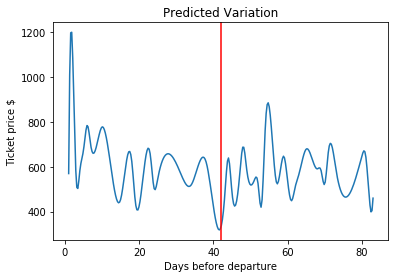

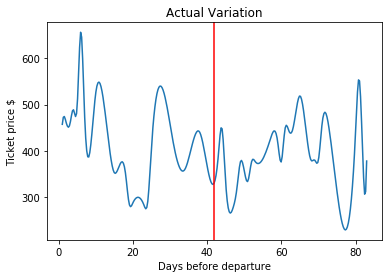

In [36]:
days_before_departure = (pd.to_datetime(departure_date, format = '%Y/%m/%d')-
                             pd.to_datetime(received_date, format = '%Y/%m/%d')).days

smoothen_and_plot_curve(x = days_remaining,  y = predicted_prices, title='Predicted Variation', 
                        days_before_departure=days_before_departure)
smoothen_and_plot_curve(x=days_remaining, y =test_df_prices, title='Actual Variation', 
                        days_before_departure=days_before_departure)

## Part 2: Recommend whether to buy now or later

#### General references: 
1. https://www.cheapair.com/blog/2018-airfare-study-the-best-time-to-buy-flights-based-on-917-million-airfares/?fbclid=IwAR17vGQXTBHdRaJRSQos7pnhd_p6lX4vxJ75XmLw_VT32wV28TB11k_rYKk

#### Medium articles and research papers

2. https://medium.com/@neal_lathia/reading-the-machine-learning-behind-farecast-ca67cbd48665
3. https://www.isi.edu/integration/papers/etzioni03-kdd.pdf

#### Google flights:

4. https://blog.google/products/flights-hotels/making-travel-planning-less-stressful-holiday-season/
5. https://venturebeat.com/2019/08/08/google-brings-airfare-insights-and-travel-recommendations-to-trips/

#### Kayak:

6. https://www.kayak.com/price-trend-explanation

#### Function to generate data given a departure date, return date and recieved date

In [37]:

imp = SimpleImputer(missing_values='NaN', strategy='most_frequent')

def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

def create_input_data(origin='BOS' , destination='CUN', departure_odate='' , 
                      return_odate='' ,received_date=''):
    
    data = pd.read_csv('boscun-longitudinal.csv')
    input_data = data.head(1)

    for c in input_data.columns:
    
        if c == 'received_date':
            input_data[c][0] = received_date
        elif c == 'departure_odate':
            input_data[c][0] = departure_odate
        elif c == 'return_odate':
            input_data[c][0] = return_odate
        elif c == 'advance':
            advance = (pd.to_datetime(departure_odate, format = '%Y/%m/%d')-
                                 pd.to_datetime(received_date, format = '%Y/%m/%d')).days
            input_data[c][0] = advance
        elif c in ['search_id', 'origin', 'destination', 'received_ms', 'return_ms', 'pax_type']:
            continue
        elif c in categorical_features:
            input_data[c][0] = most_frequent(data[c])
        elif c in continuous_features:
            input_data[c][0] = np.mean(list(data[c]))
        
    input_data = input_data.append([input_data]*advance,ignore_index=True)
    input_data['advance'] = range(advance+1, 0, -1)
    input_data['received_date'] = input_data        
    return input_data

In [38]:
# Testing

create_input_data(origin='BOS' , destination='CUN', 
                  departure_odate='2020/1/1', return_odate='2020/1/4', 
                  received_date='2019/12/8')

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,...,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class
0,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,f079363a-b281-3476-b13e-d96ba6a8ad8a,1461268013357,BOS,CUN,397.0,ADT,NaN,UA,...,617,1,UA,2,25,6,True,8,E,E
1,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,f079363a-b281-3476-b13e-d96ba6a8ad8a,1461268013357,BOS,CUN,397.0,ADT,NaN,UA,...,617,1,UA,2,24,6,True,8,E,E
2,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,f079363a-b281-3476-b13e-d96ba6a8ad8a,1461268013357,BOS,CUN,397.0,ADT,NaN,UA,...,617,1,UA,2,23,6,True,8,E,E
3,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,f079363a-b281-3476-b13e-d96ba6a8ad8a,1461268013357,BOS,CUN,397.0,ADT,NaN,UA,...,617,1,UA,2,22,6,True,8,E,E
4,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,f079363a-b281-3476-b13e-d96ba6a8ad8a,1461268013357,BOS,CUN,397.0,ADT,NaN,UA,...,617,1,UA,2,21,6,True,8,E,E
5,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,f079363a-b281-3476-b13e-d96ba6a8ad8a,1461268013357,BOS,CUN,397.0,ADT,NaN,UA,...,617,1,UA,2,20,6,True,8,E,E
6,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,f079363a-b281-3476-b13e-d96ba6a8ad8a,1461268013357,BOS,CUN,397.0,ADT,NaN,UA,...,617,1,UA,2,19,6,True,8,E,E
7,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,f079363a-b281-3476-b13e-d96ba6a8ad8a,1461268013357,BOS,CUN,397.0,ADT,NaN,UA,...,617,1,UA,2,18,6,True,8,E,E
8,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,f079363a-b281-3476-b13e-d96ba6a8ad8a,1461268013357,BOS,CUN,397.0,ADT,NaN,UA,...,617,1,UA,2,17,6,True,8,E,E
9,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,f079363a-b281-3476-b13e-d96ba6a8ad8a,1461268013357,BOS,CUN,397.0,ADT,NaN,UA,...,617,1,UA,2,16,6,True,8,E,E


In [39]:

def should_you_buy_the_ticket(origin='BOS', destination='CUN', 
                              departure_date='2020/1/1', return_date='2020/1/4', 
                              received_date='2019/12/8', data=data):
    
    
    
    print 'Generating data ...'
    test_df = create_input_data(origin='BOS' , destination='CUN', departure_odate=departure_date , 
                      return_odate=return_date ,received_date=received_date)
    
    test_df = test_df.sort_values('advance')
    sample_df = test_df.loc[test_df.groupby('advance')['total_usd'].idxmin()]
    
    actual_prices = list(sample_df['total_usd'])
    days_remaining = list(sample_df['advance'])
    
    xt = preprocess_data(sample_df, kept_features, categorical_features, continuous_features)[0]
    for col in X_test.columns:
        if col not in xt.columns:
            xt[col] = 0

    predicted_prices = model.predict(xt)
    days_before_departure = (pd.to_datetime(departure_date, format = '%Y/%m/%d')-
                             pd.to_datetime(received_date, format = '%Y/%m/%d')).days
    print ''
    print 'Days before flight departure: ', days_before_departure
    print ''
    smoothen_and_plot_curve(x = days_remaining,  y = predicted_prices, title='Predicted Variation',
                           days_before_departure=days_before_departure)
    
    sample_df['predicted_price'] = predicted_prices
    current_minimum_price = sample_df[sample_df['advance'] == days_before_departure]['predicted_price'].min()
    print 'Current Minimum price is: ', current_minimum_price
    minimum_predicted_price = min(predicted_prices)
    print 'Predicted Minimum price is: ', minimum_predicted_price
    print ''
    # Say 'Buy' or 'Wait'
    if current_minimum_price <= minimum_predicted_price:
        print 'Hopper Recommendation: BUY'
    else:
        print 'Hopper Recommendation: WAIT'
    
    

Generating data ...

Days before flight departure:  90



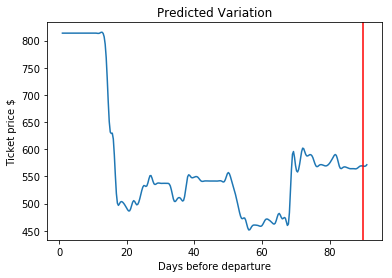

Current Minimum price is:  568.9740000000002
Predicted Minimum price is:  452.29799999999994

Hopper Recommendation: WAIT


In [40]:
should_you_buy_the_ticket(origin='BOS', destination='CUN', 
                              departure_date='2019-03-10', return_date='2019-03-14', received_date='2018-12-10')